In [1]:
import io
import os
import re
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.utils import plot_model

In [2]:
DATASET = "imdb_reviews" # datasets: "imdb_reviews", "yelp_polarity_reviews"

DROPOUT_RATE = 0.5
DENSE_HIDDEN_UNITS = 200
BATCH_SIZE = 64
NB_CLASSES = 2
BUFFER_SIZE = 10000

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2022-05-25 19:05:34.286167: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2022-05-25 19:06:35.153354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 19:06:35.303261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 19:06:35.303993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 19:06:35.306625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('type data: ', type(example))
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
type data:  <class 'tensorflow.python.framework.ops.EagerTensor'>
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. How

2022-05-25 19:06:38.274341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-25 19:06:38.330285: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


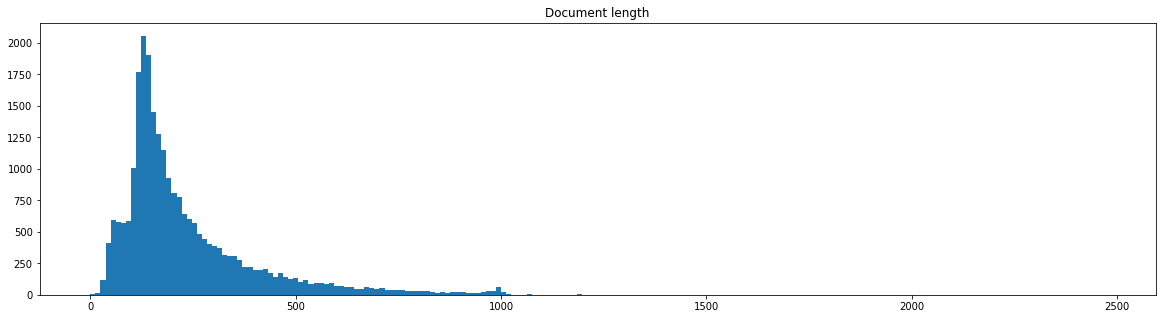

Text informations:
 - number of seq:  25000
 - max length:     2470
 - min length:     10
 - mean length:    233.77672


In [5]:
num_token = [len(str(text.numpy()).split()) for text, label in train_dataset.take(count=-1)]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title("Document length")
plt.hist(num_token, 200, density=False, range=(0,np.max(num_token)))
plt.show()

print("Text informations:")
print(f" - number of seq:  {len(num_token)}")
print(f" - max length:     {np.max(num_token)}")
print(f" - min length:     {np.min(num_token)}")
print(f" - mean length:    {np.mean(num_token)}")

In [6]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH = 400

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I saw this by chance showing on cable on wanted to like it as I thought Sandra was quite funny from what I remembered. The only facial movement I had throughout the movie was jaw dropping stunned at how awful a movie I just suffered through.<br /><br />The person who said this is one of the funniest movies of all time please point out one line, just one scene, that is even worth a chuckle.<br /><br />She is a much better singer than I remember her to be, but I didn't want to watch a lounge act.<br /><br />I think this is a movie try hard to like since they think they should and don't view it objectively."
 b"Ludicrous violations of the most basic security regs are only the beginning. It's hard to see how they achieved such abysmal trash on such a low budget. I turned it off once, then got curious to see if it could get any worse. It did."
 b"He only gets third billing (behind Arthur Treacher & Virginia Field), but this was effectively David Niven's first starring role and he

In [9]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), 
                                  '')

encoder = TextVectorization(
    standardize = custom_standardization,
    max_tokens =  VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = MAX_SEQ_LENGTH)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film'],
      dtype='<U17')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  10,  209,   11, ...,    0,    0,    0],
       [2750,    1,    5, ...,    0,    0,    0],
       [  27,   61,  202, ...,    0,    0,    0]])

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I saw this by chance showing on cable on wanted to like it as I thought Sandra was quite funny from what I remembered. The only facial movement I had throughout the movie was jaw dropping stunned at how awful a movie I just suffered through.<br /><br />The person who said this is one of the funniest movies of all time please point out one line, just one scene, that is even worth a chuckle.<br /><br />She is a much better singer than I remember her to be, but I didn't want to watch a lounge act.<br /><br />I think this is a movie try hard to like since they think they should and don't view it objectively."
Round-trip:  i saw this by chance showing on cable on wanted to like it as i thought sandra was quite funny from what i remembered the only facial movement i had throughout the movie was jaw dropping stunned at how awful a movie i just suffered through the person who said this is one of the funniest movies of all time please point out one line just one scene that is even 

In [13]:
model = Sequential([
                    encoder,
                    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
                    LSTM(128, dropout=DROPOUT_RATE),
                    Dense(64, activation='relu', kernel_regularizer='l2'),
                    Dropout(DROPOUT_RATE),
                    Dense(1, activation='sigmoid')
])

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 400)               0         
_________________________________________________________________
embedding (Embedding)        (None, 400, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,125,569
Trainable params: 1,125,569
Non-trainable params: 0
______________________________________________

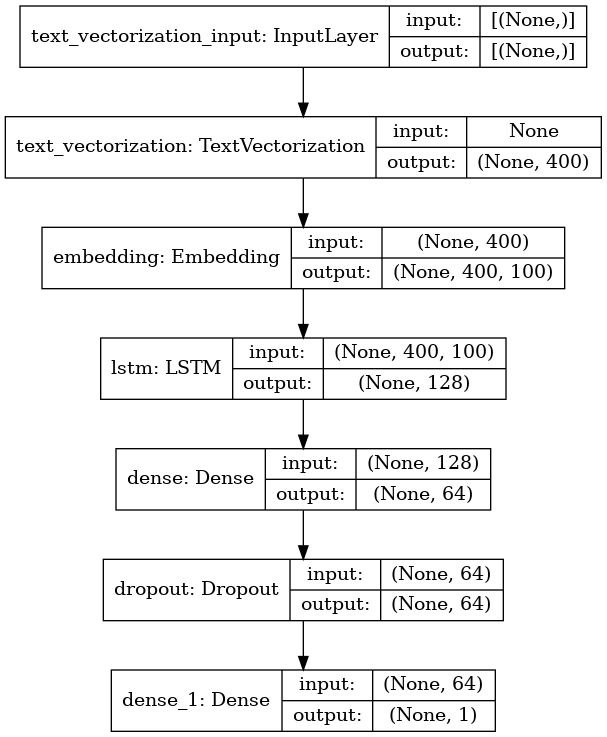

In [16]:
plot_model(model, show_shapes=True)

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2022-05-25 19:06:58.737441: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 20s 35ms/step - loss: 1.2971 - accuracy: 0.5733 - val_loss: 1.0286 - val_accuracy: 0.7719


2022-05-25 19:07:14.190456: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/10
391/391 [==============================] - 13s 32ms/step - loss: 0.7985 - accuracy: 0.8140 - val_loss: 0.6211 - val_accuracy: 0.8490


2022-05-25 19:07:26.849984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/10
391/391 [==============================] - 14s 35ms/step - loss: 0.5026 - accuracy: 0.8798 - val_loss: 0.4513 - val_accuracy: 0.8693


2022-05-25 19:07:40.723585: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4/10
391/391 [==============================] - 15s 38ms/step - loss: 0.3636 - accuracy: 0.9013 - val_loss: 0.3767 - val_accuracy: 0.8802


2022-05-25 19:07:55.888526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5/10
391/391 [==============================] - 13s 33ms/step - loss: 0.2906 - accuracy: 0.9123 - val_loss: 0.3446 - val_accuracy: 0.8771


2022-05-25 19:08:09.113189: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6/10
391/391 [==============================] - 13s 33ms/step - loss: 0.2555 - accuracy: 0.9210 - val_loss: 0.3248 - val_accuracy: 0.8818


2022-05-25 19:08:22.258068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7/10
391/391 [==============================] - 13s 33ms/step - loss: 0.2323 - accuracy: 0.9264 - val_loss: 0.3604 - val_accuracy: 0.8771


2022-05-25 19:08:42.813475: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8/10
391/391 [==============================] - 13s 32ms/step - loss: 0.2046 - accuracy: 0.9369 - val_loss: 0.3174 - val_accuracy: 0.8880


2022-05-25 19:09:02.948247: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9/10
391/391 [==============================] - 13s 33ms/step - loss: 0.1939 - accuracy: 0.9388 - val_loss: 0.3597 - val_accuracy: 0.8802


2022-05-25 19:09:16.062059: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10/10
391/391 [==============================] - 13s 32ms/step - loss: 0.1844 - accuracy: 0.9424 - val_loss: 0.3300 - val_accuracy: 0.8682


2022-05-25 19:09:36.359868: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 7s 17ms/step - loss: 0.3293 - accuracy: 0.8685
Test Loss: 0.32931047677993774
Test Accuracy: 0.8685200214385986


In [19]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

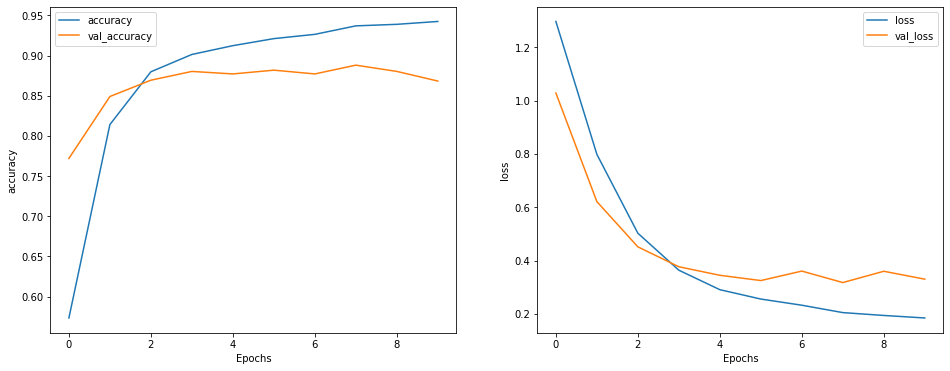

In [20]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [31]:
model1 = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM,
                              mask_zero=True),
    LSTM(256, dropout=DROPOUT_RATE, return_sequences=True),
    LSTM(128, dropout=DROPOUT_RATE, return_sequences=True),
    LSTM(64, dropout=DROPOUT_RATE),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

In [32]:
model1.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [33]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 400)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 100)          1000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 400, 256)          365568    
_________________________________________________________________
lstm_8 (LSTM)                (None, 400, 128)          197120    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

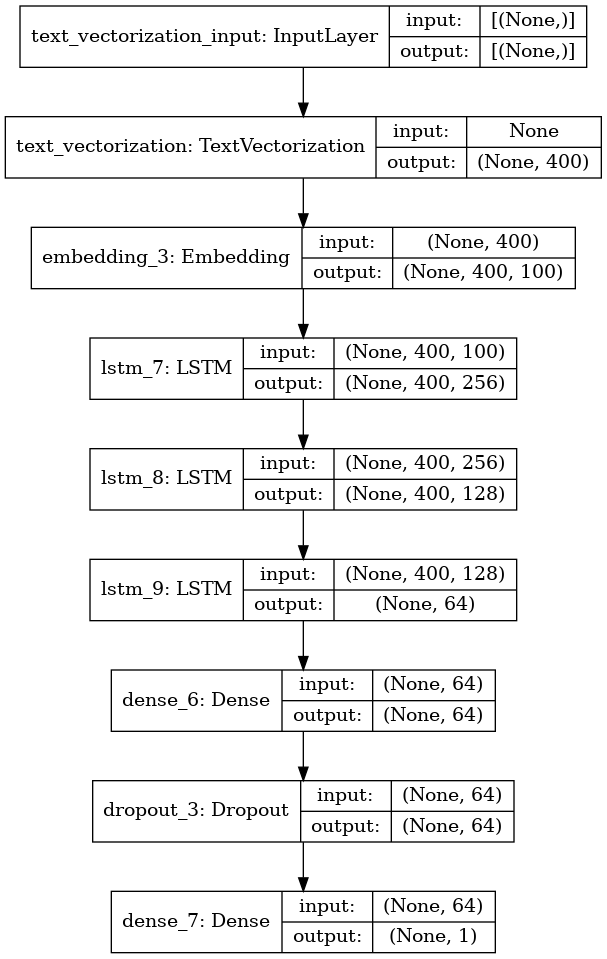

In [34]:
plot_model(model1, show_shapes=True)

In [35]:
history1 = model1.fit(train_dataset, epochs=10,
                      validation_data=test_dataset,
                      validation_steps=30)

Epoch 1/10
391/391 [==============================] - 46s 94ms/step - loss: 1.0592 - accuracy: 0.6913 - val_loss: 0.7673 - val_accuracy: 0.8427
Epoch 2/10
391/391 [==============================] - 34s 86ms/step - loss: 0.6606 - accuracy: 0.8571 - val_loss: 0.5881 - val_accuracy: 0.8646
Epoch 3/10
391/391 [==============================] - 34s 86ms/step - loss: 0.4855 - accuracy: 0.8861 - val_loss: 0.4872 - val_accuracy: 0.8604
Epoch 4/10
391/391 [==============================] - 34s 86ms/step - loss: 0.3758 - accuracy: 0.9038 - val_loss: 0.4127 - val_accuracy: 0.8667
Epoch 5/10
391/391 [==============================] - 34s 87ms/step - loss: 0.3050 - accuracy: 0.9140 - val_loss: 0.3780 - val_accuracy: 0.8740
Epoch 6/10
391/391 [==============================] - 34s 87ms/step - loss: 0.2651 - accuracy: 0.9198 - val_loss: 0.3603 - val_accuracy: 0.8802
Epoch 7/10
391/391 [==============================] - 34s 87ms/step - loss: 0.2322 - accuracy: 0.9263 - val_loss: 0.3516 - val_accuracy:

In [36]:
test_loss, test_acc = model1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 14s 35ms/step - loss: 0.3582 - accuracy: 0.8693
Test Loss: 0.3581591844558716
Test Accuracy: 0.8693199753761292


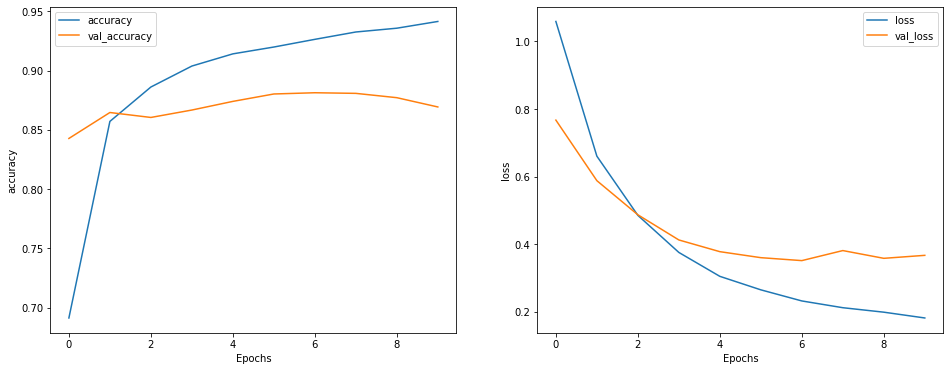

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')